<h1>Morpheus Model Tutorial: Deep Learning Galaxy Classifications for Roman</h1>

<h3>
    Ryan Hausen</br>
    Roman Science Team Community Briefing</br>
    November 19, 2021
</h3>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanhausen/roman-expo-morpheus/blob/main/Roman-Expo-Workshop.ipynb)

## Table of Contents

1. [Morpheus](#Morpheus)
1. [Big-Morpheus](#Big-Morpheus)
1. [Scaling Up Your Model: Morpheus-Core](#Scaling-Up-Your-Model:-Morpheus-Core)

## Morpheus

[Morpheus](https://morpheus-project.github.io/morpheus/) (arXiv:1906.11248, ApJS, 248, 20) is a deep learning model and software package for the pixel-level morphological classifications of large scale astronomical images.

Using a U-Net like type Convolutional Neural Network, it detects and morphologically classifies sources:

![morph](https://morpheus-project.github.io/morpheus/images/zoom_3dhst.png)

In [5]:
from IPython.display import display, HTML, IFrame, YouTubeVideo
display(HTML("<h3>GOODS South Survey</h3>"))
display(IFrame(src="http://slate.ucsc.edu/~brant/morpheus/mapv12/index_light.html", width=600, height=600))

In [ ]:
# if your running on Colab or you haven't installed morpheus 
# you need to install the package.
!pip install morpheus-astro

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from astropy.visualization import simple_norm

from morpheus.classifier import Classifier
from morpheus.data import example

plt.style.use('default')
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Example Image

Morpheus was trained on the F125W, F160W, F606W, and F850LP band images and performs best when classifying an image with data in those bands.

In [3]:
h, j, v, z = example.get_sample()

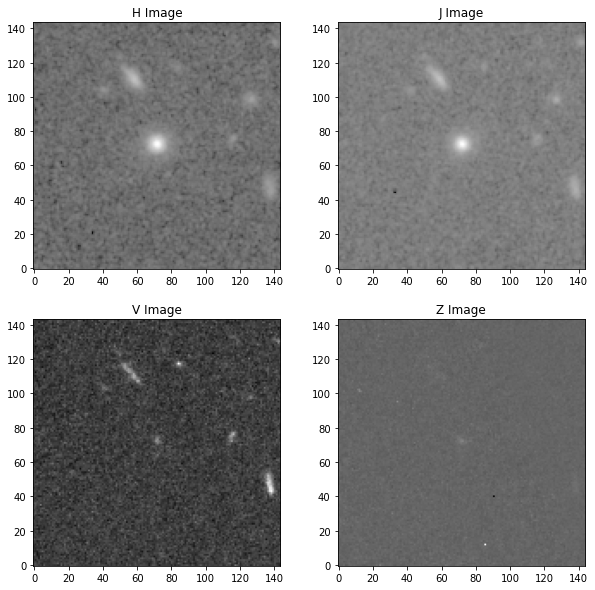

In [4]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band, s in zip(axes, [h,j,v,z], 'HJVZ', [*["log"]*2, *["linear"]*2]):
    ax.set_title(f'{band} Image')
    ax.imshow(
        arr, 
        origin='lower', 
        cmap='gray',
        norm=simple_norm(arr, stretch=s)
    )
plt.show()

## Classify Images <a name="classification"></a>

To classify an image, use [Classifer.classify](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.classify).
The arguments can be either a file path or a numpy array. The output is a dictionary that contains the
classifications as numpy arrays.

The output is a dictionary that contains a mapping for each pixel which represents the 
probability that a pixel belongs to one of the following classes:

- Spheroid
- Disk
- Irregular
- Point Source (Compact)
- Background

It also contains a mapping for `n`, which indicates how many times a classification was recorded for that pixel

The image can be any size as long as it's larger than $40\times40$, which is the classification input/output size of the model. Morpheus can take care of the rest which includes:
- Windowing input image
- Aggregating outputs into a single output image
- parallel classification over CPUs or NVIDIA GPUs

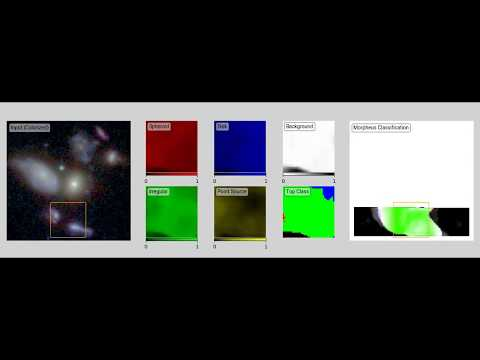

In [8]:
display(YouTubeVideo("hEL1h_dODkU", width=800))

In [9]:
classified = Classifier.classify(h=h, j=j, v=v, z=z)

classifying:   0%|          | 0/11 [00:00<?, ?batch/s]/home/ryanhausen/anaconda3/envs/roman/lib/python3.6/site-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/home/ryanhausen/anaconda3/envs/roman/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/ryanhausen/anaconda3/envs/roman/lib/python3.6/site-packages/keras/legacy_tf_layers/convolutional.py:536: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future vers

In [10]:
tf.test.gpu_device_name()

''

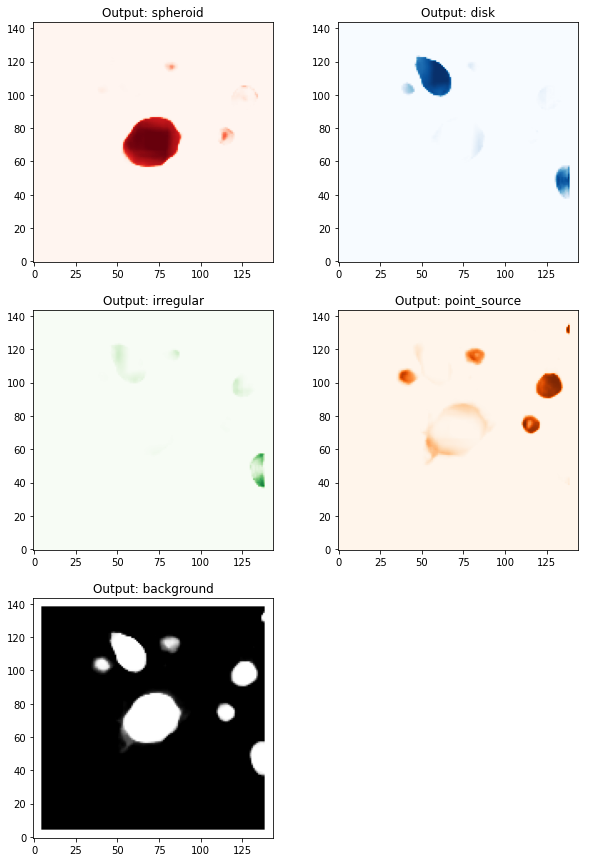

In [11]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = np.array(axes).flatten()

cmaps = ["Reds", "Blues", "Greens", "Oranges", "binary"]

for i, k in enumerate(classified):
    if k=="n":
        axes[i].axis("off")
    else:
        axes[i].set_title(f'Output: {k}')
        axes[i].imshow(
            classified[k], 
            origin='lower', 
            vmin=0, 
            vmax=1, 
            cmap=cmaps[i])
plt.show()

### Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [12]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(h, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, h, mask=mask)

Building Markers...
Watershedding...


/home/ryanhausen/anaconda3/envs/roman/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Deblending: 100%|██████████| 6/6 [00:00<00:00, 2564.02it/s]


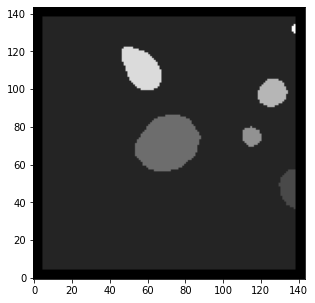

In [13]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='gray')
plt.show()

### Cataloging <a name="cataloging"></a>

Morpheus provides a cataloging functionality via [Classifier.catalog_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.catalog_from_classified)
for images that will return all of the detected sources and their morphological classifications.


In [14]:
catalog = Classifier.catalog_from_classified(classified, h, segmap)

In [15]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[44, 138]	[0.   0.69 0.31 0.  ]
2		[72, 72]	[0.98 0.   0.   0.01]
3		[76, 116]	[0.26 0.   0.   0.73]
4		[98, 126]	[0.04 0.02 0.07 0.87]
5		[110, 58]	[0.   0.95 0.05 0.  ]
6		[131, 138]	[0. 0. 0. 1.]


### Colorizing a Morphological Classification <a name="colorizing_a_morphological_classification"></a>

Use [Classifier.colorize_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified)  to make an RGB. The colors in the output have the following meanings:

- Red = Spheroid
- Blue = Disk
- Green = Irregular
- Yellow = Point Source (compact)
- Back = Background

Note when Morpheus doesn't output a strong classification for any one class they are colored white.

For more information on the coloring scheme see the [documentation](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified).

100%|██████████| 144/144 [00:00<00:00, 3559.86it/s]


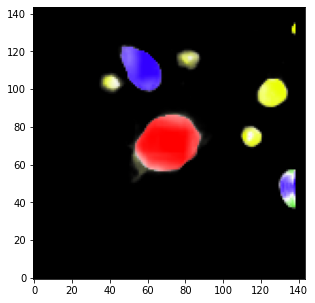

In [16]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(5, 5))
plt.imshow(rgb, origin='lower')
plt.show()

### BigMorpheus

 


BigMorpheus (Hausen & Robertson in prep) leverages the images/classifications from Morpheus to train a much larger classifier that uses a single band.
<img src="https://raw.githubusercontent.com/ryanhausen/roman-expo-morpheus/main/Morpheus-Comparison.png" width="512px" height="512px"></img>


### Scaling Up Your Model: Morpheus-Core

Morphologies are neat, but can we also do **_____**?

Probably! We have released the core "windowing" algorithm from 
Morpheus as **Morpheus-Core** (https://github.com/morpheus-project/morpheus-core) which is also pip installable.

`pip install morpheus-core`

Morpheus-Core will take care of the following:

- Windowing a larger image into batches at the size (height, width) and stride you set
- Aggregating output classifications into an output image of the same size as the input image
- Parallelizing the classification/regression of a large image over CPUs or NVIDIA GPUs